In [1]:
#rdkit関連のimport
from rdkit import Chem
from rdkit.Chem import PandasTools

#randamforest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#その他のimport
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import re

#データの規格化
def rescaling(features):
    norm_features = []
    max_value = max(features)
    min_value = min(features)
    for feature in features:
        norm_feature = (feature - min_value)/(max_value - min_value)
        norm_features.append(norm_feature)
    
    return norm_features

#SDFファイルの読み込み
mol_list  = Chem.SDMolSupplier("../../ForMolPredict/SDF_files/SOL/SOL_AllMOL.sdf",removeHs=False) 
mol_num = len(mol_list)
print("there are {} molecules".format(mol_num))

there are 1214 molecules


In [2]:
#データの抽出
#(A) lowを０それ以外を１とする
SOL_class_list = [0 if mol.GetProp('SOL_class')=='(A) low' else 1 for mol in mol_list]
mol_props = ['Volume', 'Energy', 'HOMO', 'LUMO', 'HLgap', 'Mcharge_ave', 'Mcharge_var', 'Lcharge_ave', 'Lcharge_var', 'dipole', 'Atom_num', 'Mass', 'Density']
rdkit_fp = []
calc_list = []
for mol in mol_list:
    fp = [x for x in Chem.RDKFingerprint(mol)]
    rdkit_fp.append(fp)
    mol_data = [mol.GetDoubleProp(prop) for prop in mol_props]
    calc_list.append(mol_data)
FP_df = pd.DataFrame(rdkit_fp)
Calc_df = pd.DataFrame(calc_list, columns=mol_props)
FC_df = pd.concat([Calc_df, FP_df], axis=1 )

In [3]:
#Rescaling
resc_list = []
for prop_name, prop_data in Calc_df.iteritems():
    resc_list.append(rescaling(prop_data))
rescCalc_df = pd.DataFrame(resc_list, index=mol_props)
rescCalc_df = rescCalc_df.T
rescFC_df = pd.concat([rescCalc_df, FP_df], axis=1 )

In [4]:
print('number of Fingerprint:',len(FP_df.columns))
print('number of Calclation Data:', len(Calc_df.columns))
print('number of All Data:', len(FC_df.columns))
print('number of Rescaled Calclation Data:', len(rescCalc_df.columns))
print('number of Rescaled All Data:', len(rescFC_df.columns))

number of Fingerprint: 2048
number of Calclation Data: 13
number of All Data: 2061
number of Rescaled Calclation Data: 13
number of Rescaled All Data: 2061


In [6]:
#activityのカウント
print('number of 0: ',SOL_class_list.count(0))
print('number of 1: ',SOL_class_list.count(1))

number of 0:  484
number of 1:  730


In [7]:
#Only Rdkit Finger Print
X_train, X_test, y_train, y_test = train_test_split(FP_df, SOL_class_list, random_state=0)#test_size=0.25(default)
forest = RandomForestClassifier(max_depth=100, n_estimators=500, random_state=0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test) #予測値算出
print('=======Only Rdkit Finger Print========')
print('train accuracy: {:.3f}'.format(forest.score(X_train, y_train)))
print('accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
#Only Calculation Results
X2_train, X2_test, y2_train, y2_test = train_test_split(Calc_df, SOL_class_list, random_state=0)
forest2 = RandomForestClassifier(max_depth=100, n_estimators=500, random_state=0)
forest2.fit(X2_train, y2_train)
y2_pred = forest2.predict(X2_test) #予測値算出
print('=======Only Calculation Results========')
print('train accuracy: {:.3f}'.format(forest2.score(X2_train, y2_train)))
print('accuracy: {:.3f}'.format(accuracy_score(y2_test, y2_pred)))
#Calculation Results + Rdkit Finger Print
X3_train, X3_test, y3_train, y3_test = train_test_split(FC_df, SOL_class_list, random_state=0)
forest3 = RandomForestClassifier(max_depth=100, n_estimators=500, random_state=0)
forest3.fit(X3_train, y3_train)
y3_pred = forest3.predict(X3_test) #予測値算出
print('=======Calculation Results + Rdkit Finger Print========')
print('train accuracy: {:.3f}'.format(forest3.score(X3_train, y3_train)))
print('test accuracy: {:.3f}'.format(accuracy_score(y3_test, y3_pred)))
print('/////////////Rescaled Results//////////////')
#Only Calculation Results
X4_train, X4_test, y4_train, y4_test = train_test_split(rescCalc_df, SOL_class_list, random_state=0)
forest4 = RandomForestClassifier(max_depth=100, n_estimators=500, random_state=0)
forest4.fit(X4_train, y4_train)
y4_pred = forest4.predict(X4_test) #予測値算出
print('=======Only Calculation Results========')
print('train accuracy: {:.3f}'.format(forest4.score(X4_train, y4_train)))
print('test accuracy: {:.3f}'.format(accuracy_score(y4_test, y4_pred)))
#Calculation Results + Rdkit Finger Print
X5_train, X5_test, y5_train, y5_test = train_test_split(rescFC_df, SOL_class_list, random_state=0)
forest5 = RandomForestClassifier(max_depth=100, n_estimators=500, random_state=0)
forest5.fit(X5_train, y5_train)
y5_pred = forest3.predict(X5_test) #予測値算出
print('=======Calculation Results + Rdkit Finger Print========')
print('train accuracy: {:.3f}'.format(forest5.score(X5_train, y5_train)))
print('test accuracy: {:.3f}'.format(accuracy_score(y5_test, y5_pred)))

=======Only Rdkit Finger Print========
train accuracy: 0.996
accuracy: 0.832
=======Only Calculation Results========
train accuracy: 1.000
accuracy: 0.882
=======Calculation Results + Rdkit Finger Print========
train accuracy: 1.000
test accuracy: 0.849
/////////////Rescaled Results//////////////
=======Only Calculation Results========
train accuracy: 1.000
test accuracy: 0.872
=======Calculation Results + Rdkit Finger Print========
train accuracy: 1.000
test accuracy: 0.799


In [8]:
#activityごとの評価
print('=======Only Rdkit Finger Print========')
print(classification_report(y_test,y_pred))
print('=======Only Calculation Results========')
print(classification_report(y2_test,y2_pred))
print('=======Calculation Results + Rdkit Finger Print========')
print(classification_report(y3_test,y3_pred))
print('/////////////Rescaled Results//////////////')
print('=======Only Calculation Results========')
print(classification_report(y4_test,y4_pred))
print('=======Calculation Results + Rdkit Finger Print========')
print(classification_report(y5_test,y5_pred))

=======Only Rdkit Finger Print========
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       118
           1       0.88      0.84      0.86       186

    accuracy                           0.83       304
   macro avg       0.82      0.83      0.83       304
weighted avg       0.84      0.83      0.83       304

=======Only Calculation Results========
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       118
           1       0.91      0.90      0.90       186

    accuracy                           0.88       304
   macro avg       0.87      0.88      0.88       304
weighted avg       0.88      0.88      0.88       304

=======Calculation Results + Rdkit Finger Print========
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       118
           1       0.88      0.87      0.87       186

    accuracy                           0.85    

=======Only Rdkit Finger Print========


Text(91.68, 0.5, 'true value')

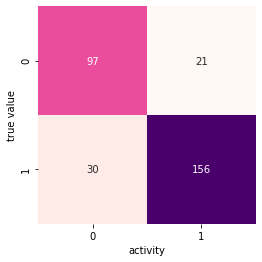

In [9]:
#confusion matrix
print('=======Only Rdkit Finger Print========')
matrix_fp = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix_fp, square=True, annot=True, cbar=False, fmt='d', cmap='RdPu')
plt.xlabel('solubility')
plt.ylabel('true value')

=======Only Calculation Results========


Text(91.68, 0.5, 'true value')

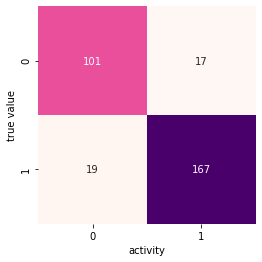

In [10]:
#confusion matrix
print('=======Only Calculation Results========')
matrix_calc = confusion_matrix(y2_test, y2_pred)
sns.heatmap(matrix_calc, square=True, annot=True, cbar=False, fmt='d', cmap='RdPu')
plt.xlabel('solubility')
plt.ylabel('true value')

=======Calculation Results + Rdkit Finger Print========


Text(91.68, 0.5, 'true value')

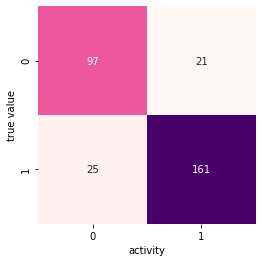

In [11]:
#confusion matrix
print('=======Calculation Results + Rdkit Finger Print========')
matrix_FC = confusion_matrix(y3_test, y3_pred)
sns.heatmap(matrix_FC, square=True, annot=True, cbar=False, fmt='d', cmap='RdPu')
plt.xlabel('solubility')
plt.ylabel('true value')

=======Only Rescaled Calculation Results========


Text(91.68, 0.5, 'true value')

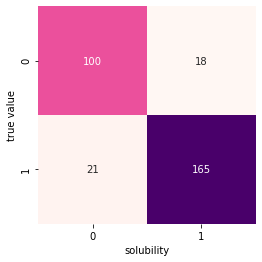

In [13]:
#confusion matrix
print('=======Only Rescaled Calculation Results========')
matrix_calc = confusion_matrix(y4_test, y4_pred)
sns.heatmap(matrix_calc, square=True, annot=True, cbar=False, fmt='d', cmap='RdPu')
plt.xlabel('solubility')
plt.ylabel('true value')

=======Rescaled Calculation Results + Rdkit Finger Print========


Text(91.68, 0.5, 'true value')

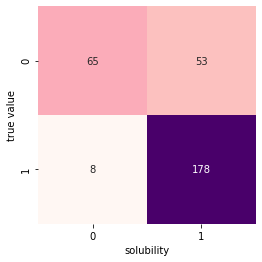

In [14]:
#confusion matrix
print('=======Rescaled Calculation Results + Rdkit Finger Print========')
matrix_FC = confusion_matrix(y5_test, y5_pred)
sns.heatmap(matrix_FC, square=True, annot=True, cbar=False, fmt='d', cmap='RdPu')
plt.xlabel('solubility')
plt.ylabel('true value')

In [15]:
# Feature Importance
fti = forest.feature_importances_  
fti2 = forest2.feature_importances_  
fti3 = forest3.feature_importances_  
fti4 = forest4.feature_importances_  
fti5 = forest5.feature_importances_ 
fti_df = pd.DataFrame(fti, columns = ['importance'])
fti_Calc_index = mol_props
fti_FC_index = mol_props+list(fti_df.index)
fti2_df = pd.DataFrame(fti2, columns =  ['importance'], index = fti_Calc_index)
fti3_df = pd.DataFrame(fti3, columns =  ['importance'], index = fti_FC_index)
fti4_df = pd.DataFrame(fti4, columns =  ['importance'], index = fti_Calc_index)
fti5_df = pd.DataFrame(fti5, columns =  ['importance'], index = fti_FC_index)
#sort
fti_df = fti_df.sort_values("importance", ascending=False)
fti2_df = fti2_df.sort_values("importance", ascending=False)
fti3_df = fti3_df.sort_values("importance", ascending=False)
fti4_df = fti4_df.sort_values("importance", ascending=False)
fti5_df = fti5_df.sort_values("importance", ascending=False)

=======Only Rdkit Finger Print========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

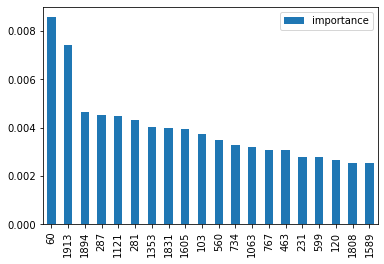

In [16]:
print('=======Only Rdkit Finger Print========')
plt.figure()
fti_df[:20].plot.bar() #Top20

=======Only Calculation Results========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

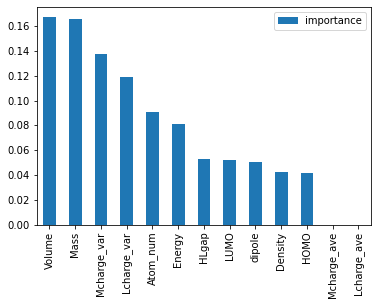

In [17]:
print('=======Only Calculation Results========')
plt.figure()
fti2_df[:20].plot.bar() #Top20

=======Calculation Results + Rdkit Finger Print========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

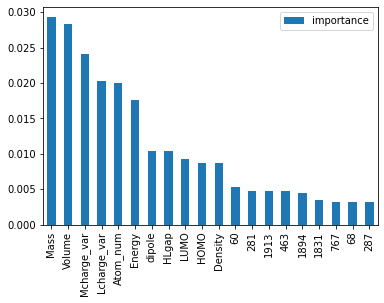

In [18]:
print('=======Calculation Results + Rdkit Finger Print========')
plt.figure()
fti3_df[:20].plot.bar() #Top20

=======Only Rescaled Calculation Results========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

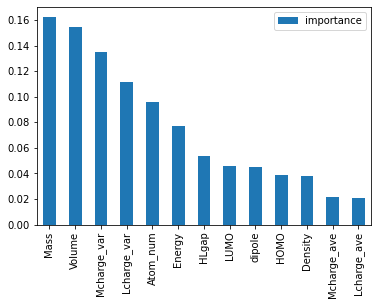

In [19]:
print('=======Only Rescaled Calculation Results========')
plt.figure()
fti4_df[:20].plot.bar() #Top20

=======Rescaled Calculation Results + Rdkit Finger Print========


<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

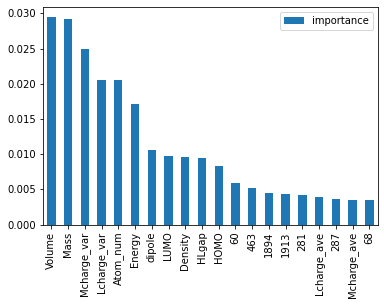

In [20]:
print('=======Rescaled Calculation Results + Rdkit Finger Print========')
plt.figure()
fti5_df[:20].plot.bar() #Top20

In [21]:
#木の数でプロット
tree_num = range(1,500)
training_acc1 = []
test_acc1 =[]
training_acc2 = []
test_acc2 =[]
training_acc3 = []
test_acc3 = []
training_acc4 = []
test_acc4 =[]
training_acc5 = []
test_acc5 = []
for N in tree_num:
    nforest1 = RandomForestClassifier(max_depth=100, n_estimators=N, random_state=0)
    nforest2 = RandomForestClassifier(max_depth=100, n_estimators=N, random_state=0)
    nforest3 = RandomForestClassifier(max_depth=100, n_estimators=N, random_state=0)
    nforest4 = RandomForestClassifier(max_depth=100, n_estimators=N, random_state=0)
    nforest5 = RandomForestClassifier(max_depth=100, n_estimators=N, random_state=0)
    nforest1.fit(X_train, y_train)
    nforest2.fit(X2_train, y2_train)
    nforest3.fit(X3_train, y3_train)
    nforest4.fit(X4_train, y4_train)
    nforest5.fit(X5_train, y5_train)
    training_acc1.append(nforest1.score(X_train, y_train))
    test_acc1.append(nforest1.score(X_test, y_test))
    training_acc2.append(nforest2.score(X2_train, y2_train))
    test_acc2.append(nforest2.score(X2_test, y2_test))
    training_acc3.append(nforest3.score(X3_train, y3_train))
    test_acc3.append(nforest3.score(X3_test, y3_test))
    training_acc4.append(nforest4.score(X4_train, y4_train))
    test_acc4.append(nforest4.score(X4_test, y4_test))
    training_acc5.append(nforest5.score(X5_train, y5_train))
    test_acc5.append(nforest5.score(X5_test, y5_test))

KeyboardInterrupt: 

In [ ]:
#graph化
fig = plt.figure(figsize=(15.0,10.0))

#Only Rdkit Finger Print
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(tree_num, training_acc1, label = 'train')
ax1.plot(tree_num, test_acc1, label = 'test')
ax1.set_title('Only Rdkit Finger Print')

#Only Calculation Results
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(tree_num, training_acc2, label = 'train')
ax2.plot(tree_num, test_acc2, label = 'test')
ax2.set_title('Only Calculation Results')

#Calculation Results + Rdkit Finger Print
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(tree_num, training_acc3, label = 'train')
ax3.plot(tree_num, test_acc3, label = 'test')
ax3.set_title('Calculation Results + Rdkit Finger Print')

#Only Rescaled Calculation Results
ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(tree_num, training_acc4, label = 'train')
ax4.plot(tree_num, test_acc4, label = 'test')
ax4.set_title('Only Rescaled Calculation Results')

#Rescaled Calculation Results + Rdkit Finger Print
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(tree_num, training_acc5, label = 'train')
ax5.plot(tree_num, test_acc5, label = 'test')
ax5.set_title('Rescaled Calculation Results + Rdkit Finger Print')

# 軸の一覧取得
axs = plt.gcf().get_axes()

# 軸毎にループ
for ax in axs:
    # 現在の軸を変更
    plt.axes(ax)
    
    # 凡例を表示
    plt.legend(loc=5)

    # グリッド
    plt.grid(linestyle='--')

    # 軸ラベル
    plt.xlabel('tree_num')
    plt.ylabel('accuracy')
    
plt.tight_layout()
plt.show()

In [ ]:
#graph化(拡大)
fig = plt.figure(figsize=(15.0,10.0))

#Only Rdkit Finger Print
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(tree_num[0:100], training_acc1[0:100], label = 'train')
ax1.plot(tree_num[0:100], test_acc1[0:100], label = 'test')
ax1.set_title('Only Rdkit Finger Print')

#Only Calculation Results
ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(tree_num[0:100], training_acc2[0:100], label = 'train')
ax2.plot(tree_num[0:100], test_acc2[0:100], label = 'test')
ax2.set_title('Only Calculation Results')

#Calculation Results + Rdkit Finger Print
ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(tree_num[0:100], training_acc3[0:100], label = 'train')
ax3.plot(tree_num[0:100], test_acc3[0:100], label = 'test')
ax3.set_title('Calculation Results + Rdkit Finger Print')

#Only Rescaled Calculation Results
ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(tree_num[0:100], training_acc4[0:100], label = 'train')
ax4.plot(tree_num[0:100], test_acc4[0:100], label = 'test')
ax4.set_title('Only Rescaled Calculation Results')

#Rescaled Calculation Results + Rdkit Finger Print
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(tree_num[0:100], training_acc5[0:100], label = 'train')
ax5.plot(tree_num[0:100], test_acc5[0:100], label = 'test')
ax5.set_title('Rescaled Calculation Results + Rdkit Finger Print')

# 軸の一覧取得
axs = plt.gcf().get_axes()

# 軸毎にループ
for ax in axs:
    # 現在の軸を変更
    plt.axes(ax)
    
    # 凡例を表示
    plt.legend(loc=5)

    # グリッド
    plt.grid(linestyle='--')

    # 軸ラベル
    plt.xlabel('tree_num')
    plt.ylabel('accuracy')
    
plt.tight_layout()
plt.show()